## KLens shift_cen branch + BinnedFit shift_cen branch

``image0 = galsim.Image(pars['ngrid'], pars['ngrid'], scale=pars['subGridPixScale'])``

In [1]:
#%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
#%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
import astropy.constants as constants

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_BinnedFit)
from binnedFit_utilities import *
from imageFit import ImageFit
from chainTool import ChainTool
from gen_mocks import gen_mock_tfCube

sys.path.append(dir_KLens)
from KLtool import *
from tfCube2 import GalaxyImage, TFCube

In [2]:
from chainconsumer import ChainConsumer

blue        = "#214F94"
red         = "#CC0204"
yellow      = "#FFA903"
gray        = "#858278"
black       = "#000000"
green       = "#73ab24"
purple      = "#8600C8"
lightblue   = "#6898FF"
lightblue2  = "#82b9e6"
yellowgreen = "#8dcd32" #"#8DE900"
lightteal   = "#7FC2BF"
teal        = "#51ABAE"
lightgray   = "#CDCDCD"

In [3]:
###### set up parameters ######

line_species='Halpha'

pars0 = {}
pars0['g1'] = 0.0
pars0['g2'] = 0.0
pars0['sini'] = 0.5

pars0['redshift'] = 0.4

pars0['aspect'] = 0.2
pars0['r_hl_image'] = 0.5
pars0['r_hl_spec'] = 0.5

pars0['theta_int'] = 0. #np.pi/3.

pars0['slitWidth'] = 0.12
pars0['ngrid'] = 256

pars0['norm'] = 0.0

pars0['Resolution'] = 5000.
pars0['expTime'] = 60.*30. #60.*30.
pars0['pixScale'] = 0.1185
pars0['nm_per_pixel'] = 0.033
pars0['throughput'] = 0.29
pars0['psfFWHM'] = 0.5

pars0['area'] = 3.14 * (1000./2.)**2 

pars0['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars0['linelist'] = linelist

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [4]:
pars0['dx_gal'] = 0.5
pars0['dy_gal'] = 0.5

In [5]:
dataInfo = gen_mock_tfCube(pars0, 'Halpha', slits='major', noise_mode=0)

/Users/hhg/Research/kinematic_lensing/repo/BinnedFit/notebooks/HH_notebooks/../../../BinnedFit/../TNGcube/TNGcube.py:835: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 324x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff8a8daa850>)

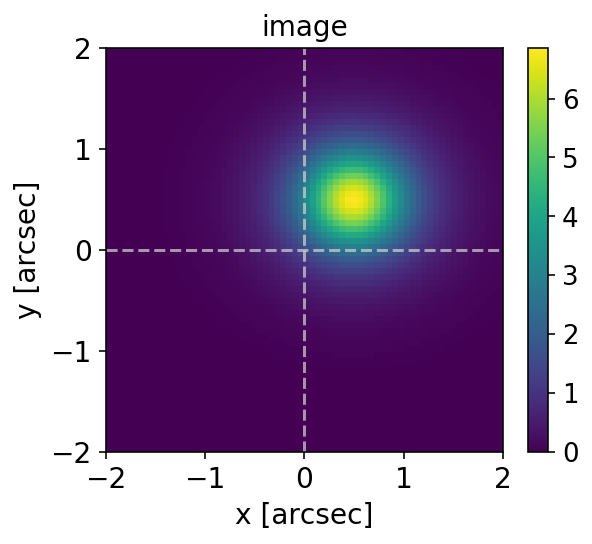

In [6]:
dataInfo['image'].display(xlim=[-2,2])

In [7]:
ImFit0 = ImageFit(image=dataInfo['image'], par_init = dataInfo['par_fid'])

In [8]:
par_in = dataInfo['par_fid'].copy()
for key in ['image_size', 'pixScale', 'ngrid', 'subGridPixScale']:
    print(key, par_in[key])

image_size 128
pixScale 0.1185
ngrid 256
subGridPixScale 0.05925


In [9]:
from IPython.display import display as ipython_display

dir_TNGcube = dir_repo+"/TNGcube"
sys.path.append(dir_TNGcube)

from TNGcube import Image

imgArr_par_in = ImFit0.forward_model(pars=par_in)
image_par_in = Image(imgArr_par_in, dataInfo['spaceGrid'], array_var=dataInfo['image_variance'])

(<Figure size 324x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff888f9b850>)

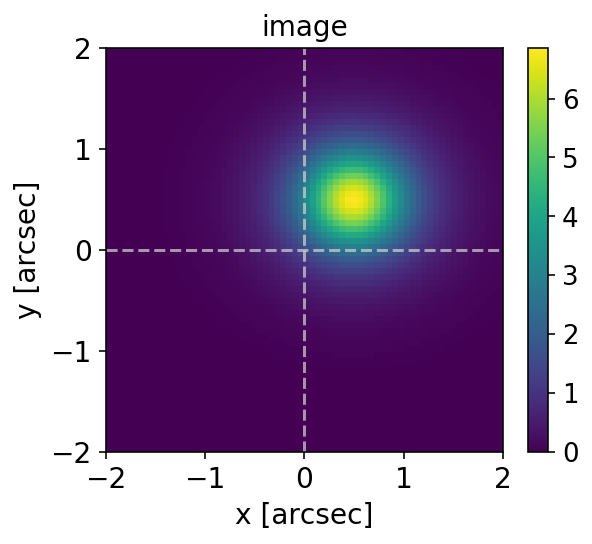

In [10]:
image_par_in.display(xlim=[-2.,2.])

In [11]:
?? ImFit0.forward_model

## Run MCMC

In [12]:
#active_par_key=['sini', 'r_hl_image', 'theta_int', 'aspect', 'flux']
active_par_key=['sini', 'r_hl_image', 'theta_int', 'flux', 'dx_gal', 'dy_gal']

chainInfo0 = ImFit0.run_MCMC(Nwalker=50, Nsteps=1000, active_par_key=active_par_key, par_fix={'g1':0., 'g2':0.})

100%|██████████| 1000/1000 [02:19<00:00,  7.15it/s]

Total MCMC time (mins): 2.335332198937734


In [13]:
active_par_test = np.zeros(len(ImFit0.active_par_key))
for j, item in enumerate(ImFit0.active_par_key):
    active_par_test[j] = ImFit0.par_init[item]
active_par_test

array([5.00000000e-01, 5.00000000e-01, 0.00000000e+00, 2.22067432e+03,
       5.00000000e-01, 5.00000000e-01])

In [14]:
%time loglike = ImFit0.cal_loglike(active_par=active_par_test)
loglike

CPU times: user 3.79 ms, sys: 1.19 ms, total: 4.98 ms
Wall time: 3.84 ms


-0.0

In [15]:
Chain_Image0 = ChainTool(chainInfo0, Nburn=25000, Nend=50000)

In [16]:
Chain_Image0.par_bestfit(select_par_key=active_par_key, statistics='max', mode=0)

{'sini': [0.43761356099471926, 0.49613496081170194, 0.5423307918316146],
 'r_hl_image': [0.4864904051852821, 0.49671703737319156, 0.5100543709200712],
 'theta_int': [-0.11479317992379301,
  -0.014362012331677332,
  0.11145815442772522],
 'flux': [2187.5558835285087, 2216.2494556704237, 2258.756476111141],
 'dx_gal': [0.4442717039451495, 0.49584773701068674, 0.5562927703400113],
 'dy_gal': [0.4491446246704492, 0.5180912329582368, 0.5615559094371084]}

In [17]:
Chain_Image0.par_maxlike(select_par_key=['flux'])

(array([2215.12031151]), -0.12510675191879272)

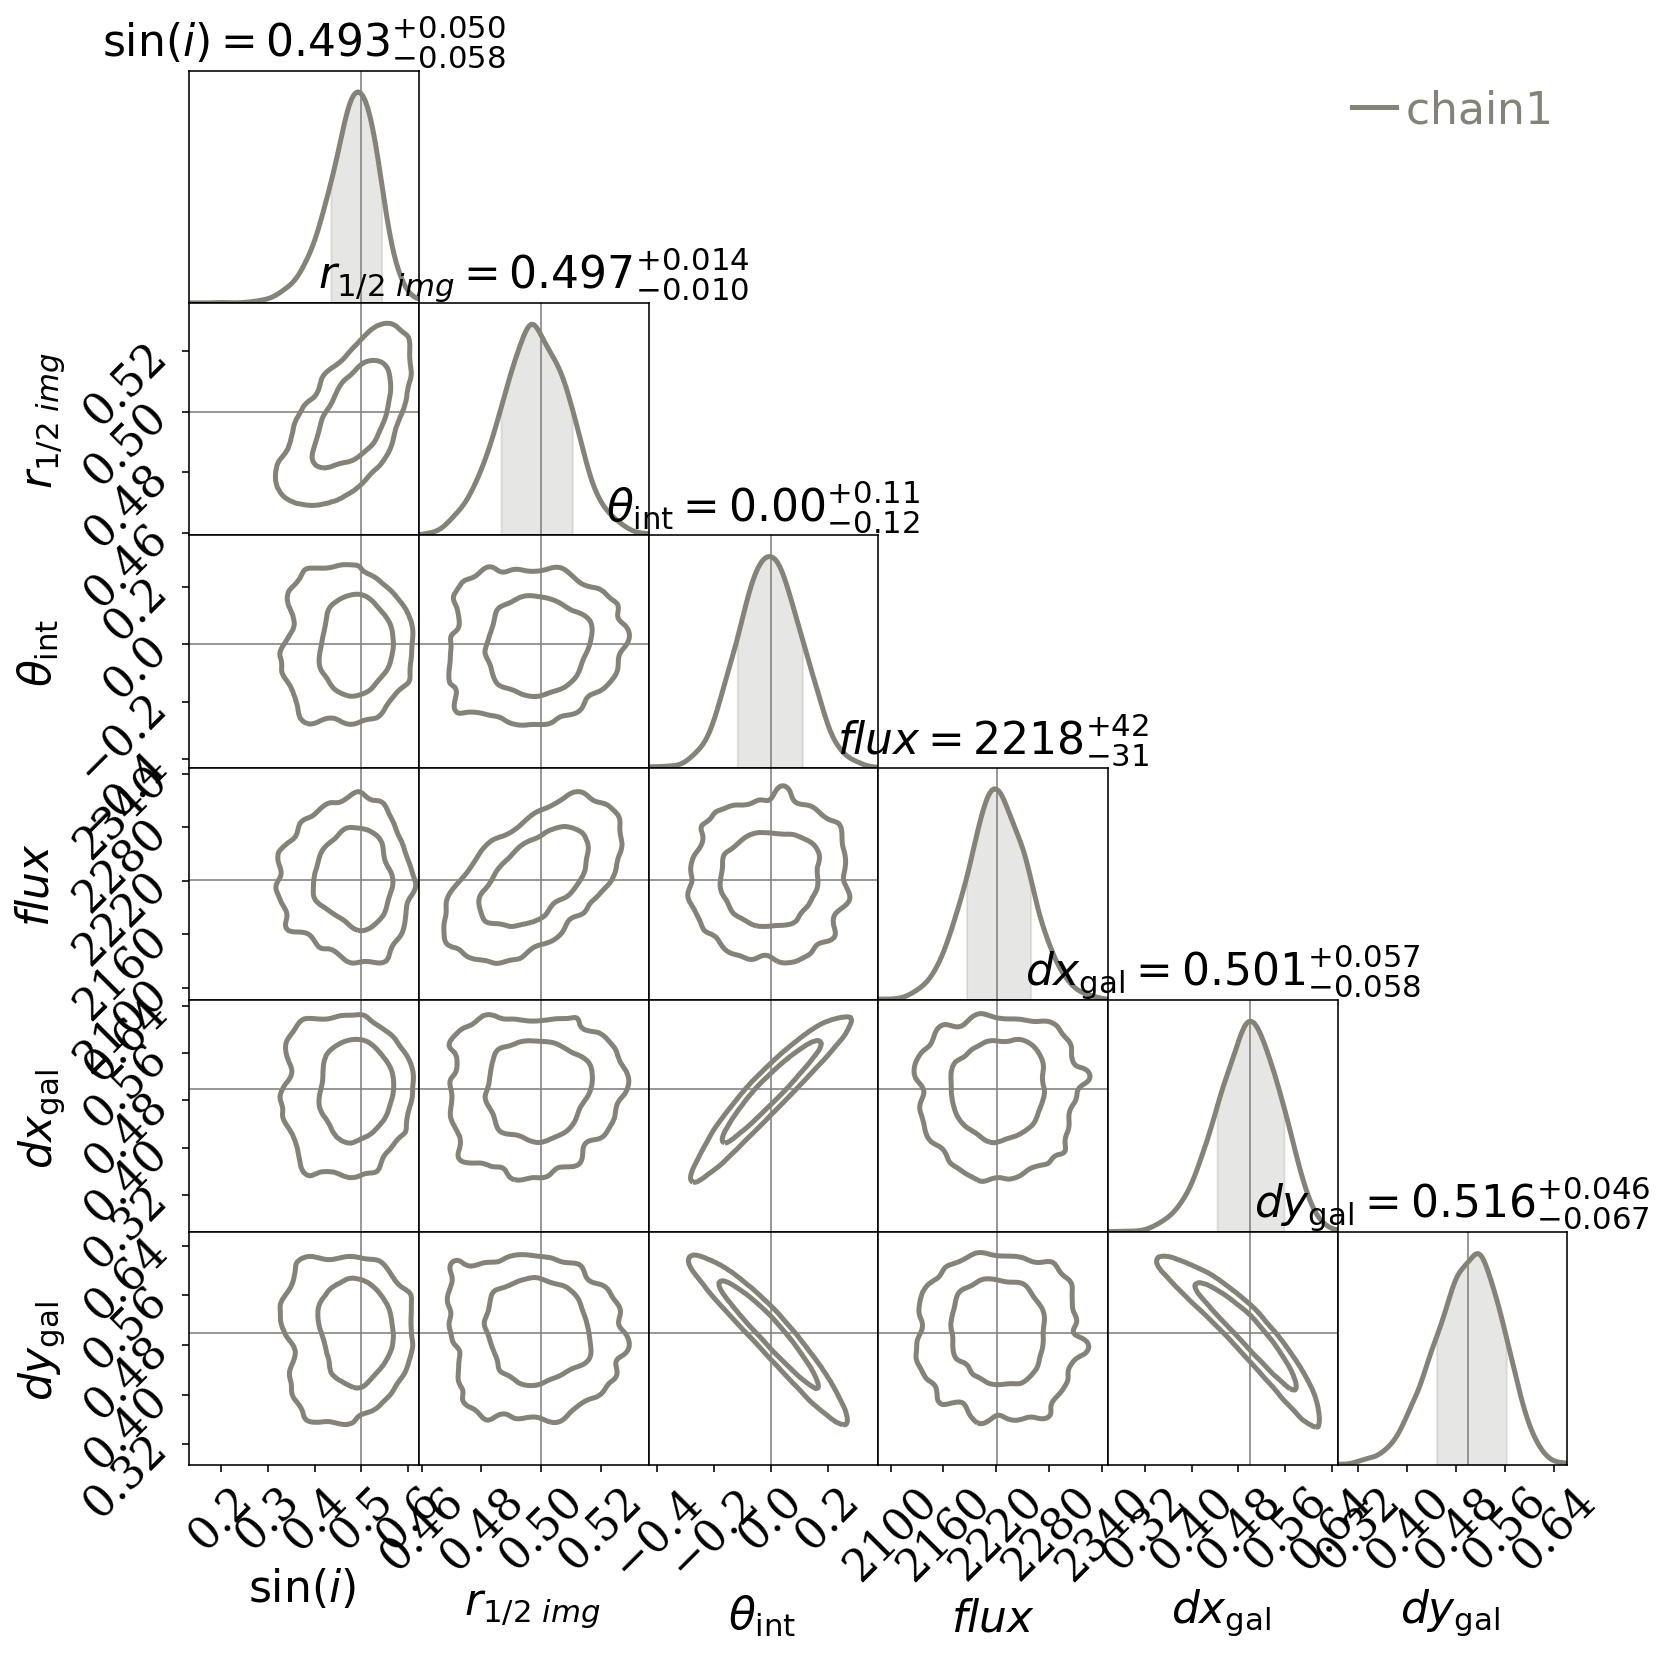

In [18]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

#select_par_key = ['sini','r_hl_image','theta_int', 'aspect','flux']
select_par_key = ['sini','r_hl_image','theta_int','flux', 'dx_gal', 'dy_gal']


parID1,parName1,par_x1 = Chain_Image0.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain_Image0.chain[:, parID1], parameters=parName1 ,name="$\mathrm{chain1}$")


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=22,tick_font_size=22
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains,
           usetex=False)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
truth_pt = [Chain_Image0.par_fid[item] for item in ImFit0.active_par_key]
fig = c.plotter.plot(legend=True, truth=truth_pt) #, truth=par_x1

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)